In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import s3fs
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss
from torch.utils.data import Subset


import getpass
import os
from PIL import Image

# Load WIDER


In [ ]:
class DataSet(Dataset):
    def __init__(self,
                ann_files,
                augs,
                img_size,
                dataset,
                ):
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
            # In this paper, we normalize the image data to [0, 1]
            # You can also use the so called 'ImageNet' Normalization method
        )
        self.anns = []
        self.load_anns()
        print(self.augment)

        # in wider dataset we use vit models
        # so transformation has been changed
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                ] 
            )        

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        idx = idx % len(self)
        ann = self.anns[idx]
        img = Image.open(ann["img_path"]).convert("RGB")

        if self.dataset == "wider":
            x, y, w, h = ann['bbox']
            img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img_area)
            img_area = self.transform(img_area)
            message = {
                "img_path": ann['img_path'],
                "target": torch.Tensor(ann['target']),
                "img": img_area
            }

In [ ]:
def make_wider(tag, value, data_path):
    img_path = os.path.join(data_path, "Image")
    ann_path = os.path.join(data_path, "Annotations")
    ann_file = os.path.join(ann_path, "wider_attribute_{}.json".format(tag))

    data = json.load(open(ann_file, "r"))

    final = []
    image_list = data['images']
    for image in image_list:
        for person in image["targets"]: # iterate over each person
            tmp = {}
            tmp['img_path'] = os.path.join(img_path, image['file_name'])
            tmp['bbox'] = person['bbox']
            attr = person["attribute"]
            for i, item in enumerate(attr):
                if item == -1:
                    attr[i] = 0
                if item == 0:
                    attr[i] = value  # pad un-specified samples
                if item == 1:
                    attr[i] = 1
            tmp["target"] = attr
            final.append(tmp)

    json.dump(final, open("data/wider/{}_wider.json".format(tag), "w"))
    print("data/wider/{}_wider.json".format(tag))

In [17]:
def _compute_classification_recall(patch_collection, label_field):
    eval_key = "eval_" + label_field
    counts = patch_collection.count_values(eval_key)
    tp, fn = counts.get(True, 0), counts.get(False, 0)
    recall = tp/float(tp + fn) if tp > 0 else 1e-6
    return recall

In [18]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [19]:
# Hyperparameters
learning_rate = 0.01379 # 0.096779
num_epochs = 3  # 200
num_workers = 2
batch_size = 256
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 52
step_size = 30
gamma = 0.1
d_temp = 1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [20]:
# # Load IdenProf dataset
# train_path = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/train'
# test_path = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

In [21]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = torchvision.models.resnet18(weights=None).cuda()

In [22]:
# # Instantiate the models
# ###################### Testing 2 ######################
# # Create instances of your models
# teacher_model = Teacher()
# teacher_model.eval()  # Set teacher model to evaluation mode
# student_model = Student()

In [23]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
class DisparityLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(DisparityLoss, self).__init__()
        self.alpha = alpha  # Weighting factor for the disparity loss

    def forward(self, recall1, recall2):
        # Calculate the absolute difference in recall
        disparity = torch.abs(recall1 - recall2)

        # Compute the loss as the weighted disparity
        loss = self.alpha * disparity

        return loss

# Example usage in your training loop
alpha = 0.1  # Weighting factor for the disparity loss
disparity_criterion = DisparityLoss(alpha)

100%|███████████████████████████████████████████| 20/20 [03:41<00:00, 11.09s/it]


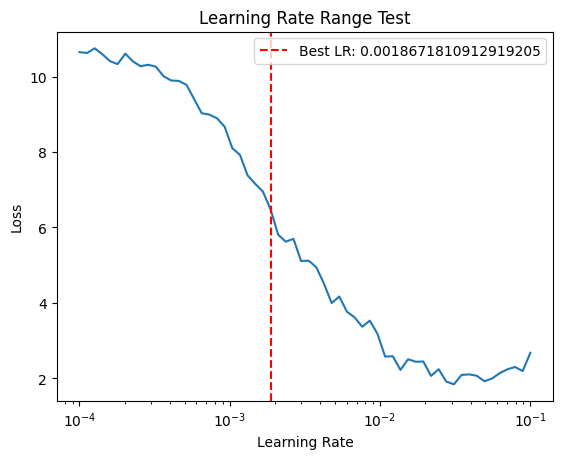

Best learning rate: 0.0018671810912919205
0.0018671810912919205


In [25]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels, annotation) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

############# input ############## 
batch_size = 16  #to find the optimal learning rate
best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(best_lr)

In [26]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=1, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels, annotations) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        epoch_disparity = 0.0
        running_recall = 0.0
        for i, (inputs, labels, annotations) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            
            # Calculate recall
            predicted_labels = torch.argmax(student_outputs, dim=1).cpu().numpy()
            batch_recall = recall_score(labels.cpu().numpy(), predicted_labels, average='weighted', zero_division=0)
            print(batch_recall)
            
            loss = alpha * kd_loss + (1 - alpha) * ce_loss 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [27]:
# Assuming the device is a CUDA device if available
num_epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation_disparity(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


100%|███████████████████████████████████████████| 20/20 [03:39<00:00, 10.95s/it]


Finished Training Teacher


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.0


  5%|██▏                                         | 1/20 [00:11<03:31, 11.12s/it]

0.0


 10%|████▍                                       | 2/20 [00:22<03:20, 11.14s/it]

0.0


 15%|██████▌                                     | 3/20 [00:33<03:08, 11.10s/it]

0.0703125


 20%|████████▊                                   | 4/20 [00:44<02:57, 11.07s/it]

0.06640625


 25%|███████████                                 | 5/20 [00:55<02:46, 11.10s/it]

0.08203125


 30%|█████████████▏                              | 6/20 [01:06<02:34, 11.06s/it]

0.09375


 35%|███████████████▍                            | 7/20 [01:17<02:23, 11.07s/it]

0.0703125


 40%|█████████████████▌                          | 8/20 [01:28<02:13, 11.08s/it]

0.0625


 45%|███████████████████▊                        | 9/20 [01:39<02:01, 11.02s/it]

0.046875


 50%|█████████████████████▌                     | 10/20 [01:50<01:51, 11.10s/it]

0.015625


 55%|███████████████████████▋                   | 11/20 [02:02<01:40, 11.12s/it]

0.0703125


 60%|█████████████████████████▊                 | 12/20 [02:13<01:28, 11.11s/it]

0.046875


 65%|███████████████████████████▉               | 13/20 [02:24<01:17, 11.09s/it]

0.0859375


 70%|██████████████████████████████             | 14/20 [02:35<01:06, 11.12s/it]

0.0546875


 75%|████████████████████████████████▎          | 15/20 [02:46<00:55, 11.09s/it]

0.078125


 80%|██████████████████████████████████▍        | 16/20 [02:57<00:44, 11.08s/it]

0.09375


 85%|████████████████████████████████████▌      | 17/20 [03:08<00:33, 11.08s/it]

0.109375


 90%|██████████████████████████████████████▋    | 18/20 [03:19<00:22, 11.08s/it]

0.09375


 95%|████████████████████████████████████████▊  | 19/20 [03:30<00:11, 11.10s/it]

0.07352941176470588


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.109375


  5%|██▏                                         | 1/20 [00:11<03:31, 11.12s/it]

0.08984375


 10%|████▍                                       | 2/20 [00:22<03:20, 11.15s/it]

0.07421875


 15%|██████▌                                     | 3/20 [00:33<03:09, 11.13s/it]

0.109375


 20%|████████▊                                   | 4/20 [00:44<02:57, 11.12s/it]

0.10546875


 25%|███████████                                 | 5/20 [00:55<02:46, 11.12s/it]

0.11328125


 30%|█████████████▏                              | 6/20 [01:06<02:36, 11.17s/it]

0.12109375


 35%|███████████████▍                            | 7/20 [01:18<02:25, 11.16s/it]

0.10546875


 40%|█████████████████▌                          | 8/20 [01:29<02:13, 11.12s/it]

0.13671875


 45%|███████████████████▊                        | 9/20 [01:40<02:01, 11.07s/it]

0.1640625


 50%|█████████████████████▌                     | 10/20 [01:51<01:50, 11.08s/it]

0.1484375


 55%|███████████████████████▋                   | 11/20 [02:02<01:39, 11.05s/it]

0.16796875


 60%|█████████████████████████▊                 | 12/20 [02:13<01:28, 11.07s/it]

0.1484375


 65%|███████████████████████████▉               | 13/20 [02:24<01:17, 11.09s/it]

0.1875


 70%|██████████████████████████████             | 14/20 [02:35<01:06, 11.11s/it]

0.14453125


 75%|████████████████████████████████▎          | 15/20 [02:46<00:55, 11.13s/it]

0.11328125


 80%|██████████████████████████████████▍        | 16/20 [02:57<00:44, 11.10s/it]

0.1640625


 85%|████████████████████████████████████▌      | 17/20 [03:08<00:33, 11.06s/it]

0.13671875


 90%|██████████████████████████████████████▋    | 18/20 [03:19<00:22, 11.03s/it]

0.17578125


 95%|████████████████████████████████████████▊  | 19/20 [03:30<00:11, 11.00s/it]

0.19117647058823528


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.16796875


  5%|██▏                                         | 1/20 [00:11<03:32, 11.16s/it]

0.15234375


 10%|████▍                                       | 2/20 [00:22<03:18, 11.05s/it]

0.171875


 15%|██████▌                                     | 3/20 [00:33<03:07, 11.05s/it]

0.13671875


 20%|████████▊                                   | 4/20 [00:44<02:56, 11.01s/it]

0.203125


 25%|███████████                                 | 5/20 [00:55<02:45, 11.02s/it]

0.19140625


 30%|█████████████▏                              | 6/20 [01:06<02:34, 11.02s/it]

0.1328125


 35%|███████████████▍                            | 7/20 [01:17<02:23, 11.03s/it]

0.15625


 40%|█████████████████▌                          | 8/20 [01:28<02:12, 11.04s/it]

0.15625


 45%|███████████████████▊                        | 9/20 [01:39<02:00, 11.00s/it]

0.171875


 50%|█████████████████████▌                     | 10/20 [01:50<01:49, 10.98s/it]

0.17578125


 55%|███████████████████████▋                   | 11/20 [02:01<01:38, 10.96s/it]

0.171875


 60%|█████████████████████████▊                 | 12/20 [02:11<01:27, 10.93s/it]

0.1484375


 65%|███████████████████████████▉               | 13/20 [02:22<01:16, 10.92s/it]

0.2109375


 70%|██████████████████████████████             | 14/20 [02:33<01:05, 10.93s/it]

0.171875


 75%|████████████████████████████████▎          | 15/20 [02:44<00:54, 10.96s/it]

0.19140625


 80%|██████████████████████████████████▍        | 16/20 [02:55<00:43, 10.99s/it]

0.203125


 85%|████████████████████████████████████▌      | 17/20 [03:06<00:32, 10.95s/it]

0.1875


 90%|██████████████████████████████████████▋    | 18/20 [03:17<00:21, 10.97s/it]

0.21484375


 95%|████████████████████████████████████████▊  | 19/20 [03:28<00:10, 10.99s/it]

0.20588235294117646


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.16796875


  5%|██▏                                         | 1/20 [00:11<03:29, 11.02s/it]

0.21484375


 10%|████▍                                       | 2/20 [00:22<03:18, 11.04s/it]

0.1953125


 15%|██████▌                                     | 3/20 [00:33<03:07, 11.05s/it]

0.234375


 20%|████████▊                                   | 4/20 [00:44<02:56, 11.06s/it]

0.1796875


 25%|███████████                                 | 5/20 [00:55<02:45, 11.04s/it]

0.19140625


 30%|█████████████▏                              | 6/20 [01:06<02:34, 11.04s/it]

0.1796875


 35%|███████████████▍                            | 7/20 [01:17<02:22, 10.99s/it]

0.21875


 40%|█████████████████▌                          | 8/20 [01:28<02:11, 10.97s/it]

0.2109375


 45%|███████████████████▊                        | 9/20 [01:38<01:59, 10.91s/it]

0.21484375


 50%|█████████████████████▌                     | 10/20 [01:49<01:49, 10.92s/it]

0.23046875


 55%|███████████████████████▋                   | 11/20 [02:00<01:38, 10.94s/it]

0.20703125


 60%|█████████████████████████▊                 | 12/20 [02:11<01:27, 10.94s/it]

0.21875


 65%|███████████████████████████▉               | 13/20 [02:22<01:16, 10.94s/it]

0.1796875


 70%|██████████████████████████████             | 14/20 [02:33<01:05, 10.99s/it]

0.21484375


 75%|████████████████████████████████▎          | 15/20 [02:44<00:54, 10.98s/it]

0.21875


 80%|██████████████████████████████████▍        | 16/20 [02:55<00:44, 11.02s/it]

0.23828125


 85%|████████████████████████████████████▌      | 17/20 [03:06<00:33, 11.01s/it]

0.203125


 90%|██████████████████████████████████████▋    | 18/20 [03:17<00:22, 11.05s/it]

0.203125


 95%|████████████████████████████████████████▊  | 19/20 [03:28<00:11, 11.04s/it]

0.16911764705882354


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.21875


  5%|██▏                                         | 1/20 [00:10<03:26, 10.87s/it]

0.203125


 10%|████▍                                       | 2/20 [00:21<03:16, 10.90s/it]

0.21875


 15%|██████▌                                     | 3/20 [00:32<03:06, 10.96s/it]

0.17578125


 20%|████████▊                                   | 4/20 [00:43<02:54, 10.91s/it]

0.18359375


 25%|███████████                                 | 5/20 [00:54<02:43, 10.93s/it]

0.22265625


 30%|█████████████▏                              | 6/20 [01:05<02:33, 10.93s/it]

0.19921875


 35%|███████████████▍                            | 7/20 [01:16<02:21, 10.91s/it]

0.265625


 40%|█████████████████▌                          | 8/20 [01:27<02:11, 10.94s/it]

0.19921875


 45%|███████████████████▊                        | 9/20 [01:38<02:00, 10.97s/it]

0.25390625


 50%|█████████████████████▌                     | 10/20 [01:49<01:49, 10.95s/it]

0.23828125


 55%|███████████████████████▋                   | 11/20 [02:00<01:38, 10.98s/it]

0.20703125


 60%|█████████████████████████▊                 | 12/20 [02:11<01:27, 10.97s/it]

0.19140625


 65%|███████████████████████████▉               | 13/20 [02:22<01:16, 10.99s/it]

0.2109375


 70%|██████████████████████████████             | 14/20 [02:33<01:05, 10.99s/it]

0.24609375


 75%|████████████████████████████████▎          | 15/20 [02:44<00:55, 11.02s/it]

0.25


 80%|██████████████████████████████████▍        | 16/20 [02:55<00:44, 11.06s/it]

0.234375


 85%|████████████████████████████████████▌      | 17/20 [03:06<00:33, 11.05s/it]

0.1875


 90%|██████████████████████████████████████▋    | 18/20 [03:17<00:22, 11.05s/it]

0.296875


 95%|████████████████████████████████████████▊  | 19/20 [03:28<00:11, 11.08s/it]

0.22794117647058823


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.25


  5%|██▏                                         | 1/20 [00:11<03:32, 11.18s/it]

0.234375


 10%|████▍                                       | 2/20 [00:22<03:20, 11.16s/it]

0.23046875


 15%|██████▌                                     | 3/20 [00:33<03:09, 11.14s/it]

0.20703125


 20%|████████▊                                   | 4/20 [00:44<02:57, 11.12s/it]

0.23828125


 25%|███████████                                 | 5/20 [00:55<02:46, 11.12s/it]

0.2734375


 30%|█████████████▏                              | 6/20 [01:06<02:34, 11.07s/it]

0.2421875


 35%|███████████████▍                            | 7/20 [01:17<02:23, 11.06s/it]

0.2421875


 40%|█████████████████▌                          | 8/20 [01:28<02:12, 11.08s/it]

0.265625


 45%|███████████████████▊                        | 9/20 [01:39<02:01, 11.04s/it]

0.2734375


 50%|█████████████████████▌                     | 10/20 [01:50<01:50, 11.04s/it]

0.265625


 55%|███████████████████████▋                   | 11/20 [02:01<01:39, 11.05s/it]

0.265625


 60%|█████████████████████████▊                 | 12/20 [02:12<01:28, 11.01s/it]

0.2265625


 65%|███████████████████████████▉               | 13/20 [02:23<01:17, 11.02s/it]

0.28125


 70%|██████████████████████████████             | 14/20 [02:34<01:05, 10.97s/it]

0.1796875


 75%|████████████████████████████████▎          | 15/20 [02:45<00:55, 11.01s/it]

0.27734375


 80%|██████████████████████████████████▍        | 16/20 [02:56<00:43, 10.99s/it]

0.203125


 85%|████████████████████████████████████▌      | 17/20 [03:07<00:32, 10.99s/it]

0.3046875


 90%|██████████████████████████████████████▋    | 18/20 [03:18<00:21, 10.97s/it]

0.1796875


 95%|████████████████████████████████████████▊  | 19/20 [03:29<00:10, 10.96s/it]

0.25735294117647056


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.3046875


  5%|██▏                                         | 1/20 [00:11<03:30, 11.05s/it]

0.25


 10%|████▍                                       | 2/20 [00:21<03:16, 10.89s/it]

0.2421875


 15%|██████▌                                     | 3/20 [00:32<03:07, 11.01s/it]

0.28125


 20%|████████▊                                   | 4/20 [00:43<02:55, 10.98s/it]

0.234375


 25%|███████████                                 | 5/20 [00:54<02:44, 10.98s/it]

0.30078125


 30%|█████████████▏                              | 6/20 [01:06<02:34, 11.03s/it]

0.265625


 35%|███████████████▍                            | 7/20 [01:17<02:23, 11.04s/it]

0.2734375


 40%|█████████████████▌                          | 8/20 [01:28<02:12, 11.03s/it]

0.32421875


 45%|███████████████████▊                        | 9/20 [01:38<02:00, 10.99s/it]

0.234375


 50%|█████████████████████▌                     | 10/20 [01:50<01:50, 11.02s/it]

0.21875


 55%|███████████████████████▋                   | 11/20 [02:01<01:39, 11.06s/it]

0.27734375


 60%|█████████████████████████▊                 | 12/20 [02:12<01:28, 11.08s/it]

0.30078125


 65%|███████████████████████████▉               | 13/20 [02:23<01:17, 11.03s/it]

0.25390625


 70%|██████████████████████████████             | 14/20 [02:34<01:06, 11.02s/it]

0.2734375


 75%|████████████████████████████████▎          | 15/20 [02:45<00:55, 11.04s/it]

0.234375


 80%|██████████████████████████████████▍        | 16/20 [02:56<00:44, 11.05s/it]

0.328125


 85%|████████████████████████████████████▌      | 17/20 [03:07<00:32, 10.99s/it]

0.2578125


 90%|██████████████████████████████████████▋    | 18/20 [03:18<00:21, 10.98s/it]

0.2734375


 95%|████████████████████████████████████████▊  | 19/20 [03:29<00:10, 11.00s/it]

0.3014705882352941


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.23046875


  5%|██▏                                         | 1/20 [00:11<03:29, 11.05s/it]

0.28515625


 10%|████▍                                       | 2/20 [00:22<03:19, 11.06s/it]

0.2734375


 15%|██████▌                                     | 3/20 [00:33<03:07, 11.03s/it]

0.30078125


 20%|████████▊                                   | 4/20 [00:44<02:56, 11.03s/it]

0.296875


 25%|███████████                                 | 5/20 [00:54<02:44, 10.96s/it]

0.29296875


 30%|█████████████▏                              | 6/20 [01:05<02:33, 10.96s/it]

0.27734375


 35%|███████████████▍                            | 7/20 [01:16<02:22, 10.97s/it]

0.2578125


 40%|█████████████████▌                          | 8/20 [01:28<02:12, 11.05s/it]

0.2734375


 45%|███████████████████▊                        | 9/20 [01:39<02:01, 11.07s/it]

0.3359375


 50%|█████████████████████▌                     | 10/20 [01:50<01:50, 11.05s/it]

0.24609375


 55%|███████████████████████▋                   | 11/20 [02:01<01:39, 11.05s/it]

0.30078125


 60%|█████████████████████████▊                 | 12/20 [02:12<01:28, 11.04s/it]

0.28125


 65%|███████████████████████████▉               | 13/20 [02:23<01:17, 11.02s/it]

0.3125


 70%|██████████████████████████████             | 14/20 [02:34<01:06, 11.03s/it]

0.23046875


 75%|████████████████████████████████▎          | 15/20 [02:45<00:54, 11.00s/it]

0.3046875


 80%|██████████████████████████████████▍        | 16/20 [02:56<00:43, 10.95s/it]

0.25390625


 85%|████████████████████████████████████▌      | 17/20 [03:07<00:32, 10.97s/it]

0.2890625


 90%|██████████████████████████████████████▋    | 18/20 [03:18<00:21, 10.98s/it]

0.3359375


 95%|████████████████████████████████████████▊  | 19/20 [03:29<00:10, 10.95s/it]

0.29411764705882354


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.26171875


  5%|██▏                                         | 1/20 [00:11<03:30, 11.07s/it]

0.3203125


 10%|████▍                                       | 2/20 [00:21<03:16, 10.90s/it]

0.26953125


 15%|██████▌                                     | 3/20 [00:32<03:05, 10.93s/it]

0.27734375


 20%|████████▊                                   | 4/20 [00:43<02:55, 10.98s/it]

0.3359375


 25%|███████████                                 | 5/20 [00:54<02:45, 11.02s/it]

0.3046875


 30%|█████████████▏                              | 6/20 [01:05<02:33, 10.98s/it]

0.359375


 35%|███████████████▍                            | 7/20 [01:16<02:22, 10.98s/it]

0.30859375


 40%|█████████████████▌                          | 8/20 [01:27<02:11, 10.99s/it]

0.3359375


 45%|███████████████████▊                        | 9/20 [01:38<02:00, 11.00s/it]

0.29296875


 50%|█████████████████████▌                     | 10/20 [01:49<01:49, 11.00s/it]

0.33984375


 55%|███████████████████████▋                   | 11/20 [02:00<01:38, 10.96s/it]

0.32421875


 60%|█████████████████████████▊                 | 12/20 [02:11<01:28, 11.00s/it]

0.28515625


 65%|███████████████████████████▉               | 13/20 [02:22<01:16, 11.00s/it]

0.33984375


 70%|██████████████████████████████             | 14/20 [02:34<01:06, 11.06s/it]

0.34765625


 75%|████████████████████████████████▎          | 15/20 [02:45<00:55, 11.09s/it]

0.33203125


 80%|██████████████████████████████████▍        | 16/20 [02:56<00:44, 11.12s/it]

0.26953125


 85%|████████████████████████████████████▌      | 17/20 [03:07<00:33, 11.10s/it]

0.30859375


 90%|██████████████████████████████████████▋    | 18/20 [03:18<00:22, 11.08s/it]

0.3203125


 95%|████████████████████████████████████████▊  | 19/20 [03:29<00:11, 11.12s/it]

0.3088235294117647


  0%|                                                    | 0/20 [00:00<?, ?it/s]

0.36328125


  5%|██▏                                         | 1/20 [00:10<03:28, 10.95s/it]

0.3515625


 10%|████▍                                       | 2/20 [00:22<03:18, 11.02s/it]

0.28515625


 15%|██████▌                                     | 3/20 [00:33<03:07, 11.03s/it]

0.30859375


 20%|████████▊                                   | 4/20 [00:44<02:56, 11.04s/it]

0.35546875


 25%|███████████                                 | 5/20 [00:55<02:45, 11.06s/it]

0.33203125


 30%|█████████████▏                              | 6/20 [01:06<02:34, 11.04s/it]

0.3515625


 35%|███████████████▍                            | 7/20 [01:17<02:24, 11.11s/it]

0.3203125


 40%|█████████████████▌                          | 8/20 [01:28<02:12, 11.08s/it]

0.29296875


 45%|███████████████████▊                        | 9/20 [01:39<02:01, 11.02s/it]

0.3515625


 50%|█████████████████████▌                     | 10/20 [01:50<01:50, 11.04s/it]

0.2578125


 55%|███████████████████████▋                   | 11/20 [02:01<01:39, 11.07s/it]

0.33203125


 60%|█████████████████████████▊                 | 12/20 [02:12<01:28, 11.07s/it]

0.375


 65%|███████████████████████████▉               | 13/20 [02:32<01:22, 11.77s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/W210-Capstone/sa_5035688.jpg'

In [178]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_prof.pth')
torch.save(student_model, 'student_model_ckd_prof.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_prof.pth')
torch.save(teacher_model, 'teacher_model_ckd_prof.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


In [ ]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [ ]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [ ]:
performance_metrics

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model = torchvision.models.resnet34(weights=None)

weights_path = 'teacher_model_weights_ckd_prof.pth'

teacher_model.load_state_dict(torch.load(weights_path))

student_model = torchvision.models.resnet18(weights=None)

weights_path = 'student_model_weights_ckd_prof.pth'

student_model.load_state_dict(torch.load(weights_path))

# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [32]:
for i, (image, label, annot) in enumerate(trainloader): 
    print(i)


0
